## Sine wave modeling

2023-01-06 23:52:14.188291: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 23:52:14.271176: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 23:52:14.272442: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


  0%|          | 0/499 [00:00<?, ?it/s]

2023-01-06 23:52:15.163131: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-01-06 23:52:15.163170: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
/tmp/ipykernel_4897/4202734690.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys).squeeze()


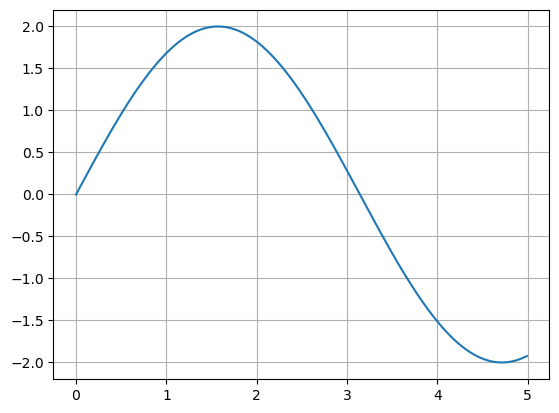

In [1]:
import numpy as np

from models import LinearDiscreteModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
plt.rcParams['axes.grid'] = True

%matplotlib inline

freq = 1
Magnitude = 2
dt = 0.01
shift = 1.5

A = np.array([[0, 1], 
            [-freq**2, 0]])

B = np.zeros((2, 1))
C = np.array([[1, 0]])

init_state = np.array([[0], [Magnitude * freq]])

model = LinearDiscreteModel(A, B, C, init_state, dt, matrix_exp_iterations=20)

a = np.arange(0, 5, step=dt)
ys = [0]

for i in tqdm(a[1:]):
    y = model.step(dt=dt)
    ys.append(y)

ys = np.array(ys).squeeze()
plt.plot(a, ys)
plt.show()

## Extended and Unscented Kalman Filter

  0%|          | 0/2500 [00:00<?, ?it/s]

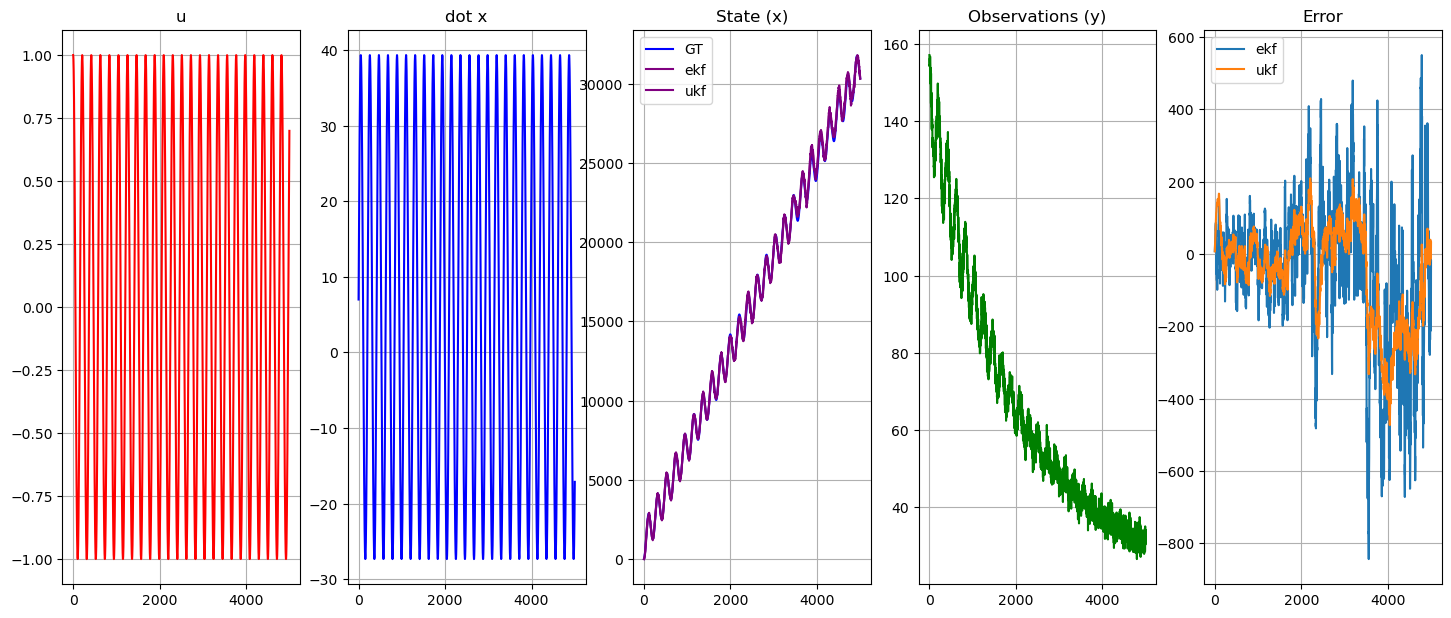

EKF MSE: 10118.18
UKF MSE: 7218.317


In [5]:
from tqdm.auto import tqdm
import numpy as np
import jax.numpy as jnp
from jax import jit
from matplotlib import pyplot as plt

plt.rcParams['axes.grid'] = True

from models import DiscreteModel, ExtendedKalmanFilter, UnscentedKalmanFilter

state_f = lambda x, u, dt: jnp.array([[1, dt], [0, 1]]) @ x + jnp.array([[0], [dt]]) @ u
# state_f = lambda x, u, dt: jnp.array([[1, 0], [0, 1]]) @ x + jnp.array([[0], [1]]) @ u
# state_f = lambda x, u, dt: jnp.array([[1, 0], [0, 1]], dtype=np.float32) @ x \
#                             + jnp.array([[0], [1]], dtype=np.float32) @ u
# out_f = lambda x: jnp.sqrt(jnp.abs(x[:1]))
# out_f = lambda x: jnp.sin(0.1 * x[:1])
# out_f = lambda x: x
# out_f = lambda x: x[:1]
out_f = lambda x: 100 * jnp.arctan(1 / (0.0001 * x[:1]))
# out_f = lambda x: 100 * jnp.sin(0.01 * x[:1])


model_noise_mean, model_noise_cov = 0, 0.5
obs_noise_mean, obs_noise_cov = 0., 2.0


plant = DiscreteModel(jit(state_f), 
            jit(out_f), 
            jnp.array([[0], [5.]]), 
            model_noise_f=lambda : np.random.normal(model_noise_mean, 0),
            obs_noise_f=lambda : np.random.normal(obs_noise_mean, obs_noise_cov),
            save_history=True)


init_state_mean=jnp.array([0., 1])
init_state_cov = jnp.array([[0.5, 0.], [0., 1]])

ekf = ExtendedKalmanFilter(state_f,
                out_f,
                model_noise_cov, 
                obs_noise_cov, 
                init_state_mean,
                init_state_cov
)

ukf = UnscentedKalmanFilter(state_f,
                out_f,
                model_noise_cov, 
                obs_noise_cov, 
                init_state_mean,
                init_state_cov
)



dt = 2
time_limit = 5000
a = np.linspace(0, time_limit, int(time_limit / dt), endpoint=True)

us = np.cos(0.03*a)[..., np.newaxis]

gt_states = []
obs_states = []
outs = []

for i, u in enumerate(tqdm(us)):
    out = plant.step(u, dt)
    ekf.step(u, out, dt)
    ukf.step(u, out, dt)
    outs.append(out)

gt_states = plant.get_history().squeeze()
obs_states_ekf = ekf.get_history().squeeze()
obs_states_ukf = ukf.get_history().squeeze()

outs = np.stack(outs)[..., 0]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(17.8, 7.2))
axs[0].plot(a, np.squeeze(us), color='red')
axs[0].title.set_text('u')
axs[1].plot(a, gt_states[1:, 1], color='blue')
axs[1].title.set_text('dot x')
axs[2].plot(a, gt_states[1:, 0], color='blue', label='GT')
axs[2].plot(a, obs_states_ekf[1:, 0], color='purple', label='ekf')
axs[2].plot(a, obs_states_ukf[1:, 0], color='purple', label='ukf')
axs[2].legend()
axs[2].title.set_text('State (x)')
axs[3].plot(a, outs, color='green')
axs[3].title.set_text('Observations (y)')
axs[4].plot(a, gt_states[1:, 0] - obs_states_ekf[1:, 0], label='ekf')
axs[4].plot(a, gt_states[1:, 0] - obs_states_ukf[1:, 0], label='ukf')
axs[4].legend()
axs[4].title.set_text('Error')
plt.show()

print('EKF MSE:', jnp.linalg.norm(gt_states[1:, 0] - obs_states_ekf[1:, 0]))
print('UKF MSE:', jnp.linalg.norm(gt_states[1:, 0] - obs_states_ukf[1:, 0]))



## Measure time for EKF and UKF

In [3]:
%%timeit 
ekf.step(u, out, dt)

1.66 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
%%timeit 
ukf.step(u, out, dt)

1.58 ms ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
